# Recreation of Professor Das' Deep Learning Application on the Black-Scholes Model

**Abstract**: This project is conducted for Data Mining (CSCI145) for Fall 2020 by Juan Diego Herrera and Seungho (Samuel) Lee. Expanding upon an effort to recreate the Black-Scholes option pricing model with Multilayer Perceptrons [Robert Culkin, Sanjiv R. Das, Machine Learning in Finance: The Case of Deep Learning for Option Pricing (2017)].

## Project Overview
### Background
**The Black Scholes model** is used to price put and call options by estimating the variation over time of the financial instruments. While a Geometric Brownian Motion (GBM) has been used as an assumption of the model, the assumption is often violated in practice, leading to a numerous variations of the Black-Scholes model. 

The **Black-Scholes formula for European call and put options** are:

$$C(S_0,t)=S_0N(d_1)-Ke^{-r(T-t)}N(d_2)$$
$$P(S_0,t)=Ke^{-r(T-t)}N(-d_2)-S_0N(-d_1)$$
where
- $S_0$: Stock Price
- $C(S_0,t)$: Price of the Call Option
- $K$: Exercise Price
- $(T-t)$: Time to Maturity, where T is Exercise Date

Hence, $N(d_1)$ and $N(d_2)$ are **cumulative distribution functions for a standard normal distribution**:
$$d_1=\frac{\ln\frac{S_0}{K}+(r+\frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}}$$
$$d_2=d_1-\sigma\sqrt{T-t}=\frac{\ln\frac{S_0}{K}+(r-\frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}}$$
where
- $\sigma$: Underlying Volatility (a standard deviation of log returns)
- $r$: Risk-free Interest Rate (i.e., T-bill Rate)


### Project Objectives
What we will be doing:\
1) Recreate Culkin and Das' work,\
2) See whether fitted simulated model performs well on actual data, 3) Can it perform better based on different dataset

## Methodologies
### Data

For data that we utilized in recreating the above work, we utilized same simulation data that Culkin and Das used to train and validate the fitted MLP model. On the other hand, we queried two different datasets from Bloomberg to compile for fitting the model: **Options Data** and **Underlying Stock Information**. 

[Talk about data]
1. Das' Data
2. Queried Data from Bloomberg

#### 1. Culkin and Das (2017)

To train the MLP algorithm to learn the call option pricing equation, Culkin and Das (2017) simulated a range of call option prices with ranges of different parameters:

| Parameter              |   Range           |
|:-----------------------|:------------------|
| Stock Price $(S)$      | \\$10 — \\$50     |
| Strike Price $(K)$     |  \\$7 — \\$650    |
| Maturity $(T-t)$       | 1 day to 3 years  |
| Dividend Rate $(q)$    | 0\% — 3\%         |
| Risk Free Rate $(r)$   | 1\% — 3\%         |
| Volatility $(\sigma)$  | 5\% — 90\%        |
| Call Price $(C)$       |  \\$0 — \\$328    |




## The Code
We will be using sci-kit learn's prebuilt models to train and the plot our results

### Colab link to drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')
drive

Mounted at /content/drive


<module 'google.colab.drive' from '/usr/local/lib/python3.6/dist-packages/google/colab/drive.py'>

### Importing all necessary depedencies and setting environment

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats

Set up the path and unzip the data (if necessary)

In [4]:
path = '/content/drive/My Drive/DM_FinalProj/'

In [ ]:
# Run once
# !unzip '/content/drive/My Drive/DM_FinalProj/data/BS_data.zip' -d '/content/drive/My Drive/DM_FinalProj/data/'


Archive:  /content/drive/My Drive/DM_FinalProj/data/BS_data.zip
  inflating: /content/drive/My Drive/DM_FinalProj/data/BS_training.csv  



### Importing and preparing training data

In [10]:
df = pd.read_csv(path+'data/BS_training.csv', low_memory=False)
df.head()

,Unnamed: 0,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,0,206.484182,194.386150,1.093151,0.005674,0.862692,0.058898,79.434285
1,1,79.581809,73.926431,0.843836,0.020428,0.759562,0.080634,24.975516
2,2,130.957110,154.101232,1.326027,0.019181,0.606436,0.042031,28.927743
3,3,53.020511,58.598175,0.791781,0.028475,0.572696,0.036566,8.573626
4,4,455.190704,529.570396,0.501370,0.009074,0.090578,0.044426,0.210253


Drop index column

In [11]:
df = df.drop(['Unnamed: 0'], axis= 1)

Normalizing the data (as done in Culkin and Das)

Here we take advantage that the Black-Scholes formula is linear homegenous in $C(S,K)$, so we can normalize as follows:

$C(S,K)/K = C(S/K,1)$

In [ ]:
df["Stock Price"] = df["Stock Price"]/df["Strike Price"]
df["Call Price"] = df["Call Price"]/df["Strike Price"]
df["Strike Price"] = df["Strike Price"]/df["Strike Price"]
df.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,1.062237,1.0,1.093151,0.005674,0.862692,0.058898,0.408642
1,1.076500,1.0,0.843836,0.020428,0.759562,0.080634,0.337843
2,0.849812,1.0,1.326027,0.019181,0.606436,0.042031,0.187719
3,0.904815,1.0,0.791781,0.028475,0.572696,0.036566,0.146312
4,0.859547,1.0,0.501370,0.009074,0.090578,0.044426,0.000397


### Training the model
To remain as faithful to Culkin and Das, we trained the neural network with the following parameters:
- 4 hidden fully connected layers, each with 100 neurons
- Batch size of 64
- 10 training epochs
- 20% of the training data was set apart for validation

The main difference between our model and the paper's model is that our network uses ReLU as the activation function for every layer instead of using LeakyReLU, ELU, ReLU, and ELU for the four layers. We also did not employ dropout regularization. Lastly, we opted to use "Adam" as our optimizer rather than stochastic gradient descent

Lastly, it is worth noting that our loss function is the Mean Squared Error, as this is a regression problem and already comes pre-built in sklearn

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Call Price', axis=1), 
                                                    df['Call Price'], test_size=0.2)

mlp = MLPRegressor(hidden_layer_sizes=(100,100,100,100), 
                   solver='adam', shuffle = False, batch_size=64, verbose=True,
                   max_iter= 10
                    ) 

NameError: ignored

In [ ]:
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.00032727
Iteration 2, loss = 0.00009148
Iteration 3, loss = 0.00006318
Iteration 4, loss = 0.00004793
Iteration 5, loss = 0.00003938
Iteration 6, loss = 0.00003412
Iteration 7, loss = 0.00003115
Iteration 8, loss = 0.00002848
Iteration 9, loss = 0.00002616
Iteration 10, loss = 0.00002503


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size=64, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=10, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=False, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

We now save the model for later use

In [ ]:
filename = path + 'models/BS_model.sav'
pickle.dump(mlp, open(filename, 'wb'))

## Analysis and visualizations 
We start by exploring the most basic performance metric for a regression problem: $R^2$

In [13]:
# Load the model (in case no training is necessary)
filename = path + 'models/BS_model.sav'
mlp = pickle.load(open(filename, 'rb'))

In [12]:
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

NameError: ignored

As can be seen from the above, despite of a high training $R^2$ score, results also indicate a high test score. 
% 1) Test_train_split --> randomized split and that simulated data (resembles normal) --> makes sense for high R^2

Hence, we are able to visualize as the below:

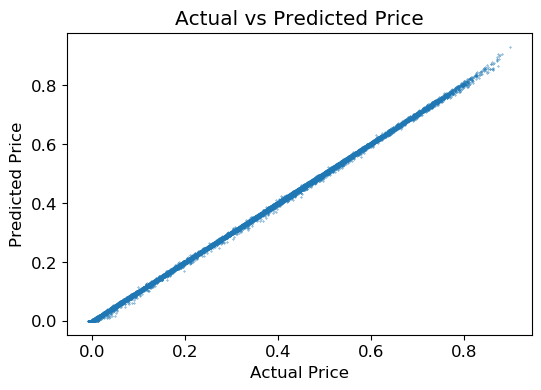

In [ ]:
preds_test = mlp.predict(X_test)
plt.figure(dpi=100)
plt.scatter(preds_test, y_test, s= 0.1)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.show()

We can also explore the distribution of both the in-sample and out of sample error

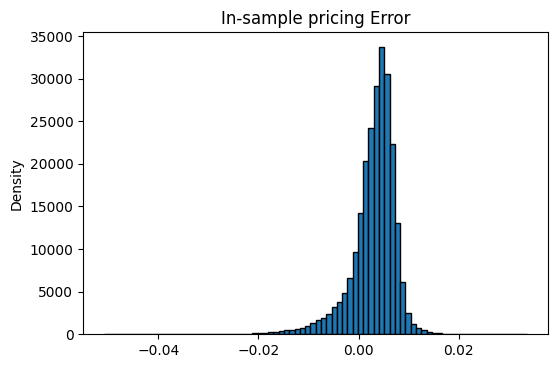

In [ ]:
# Panel 1: In-sample Pricing Error
preds_train= mlp.predict(X_train)
pricing_error_train = preds_train - y_train
plt.figure(dpi=100)
plt.hist(pricing_error_train, bins= 80, edgecolor='black')
plt.title("In-sample pricing Error")
plt.ylabel("Density")
plt.show()

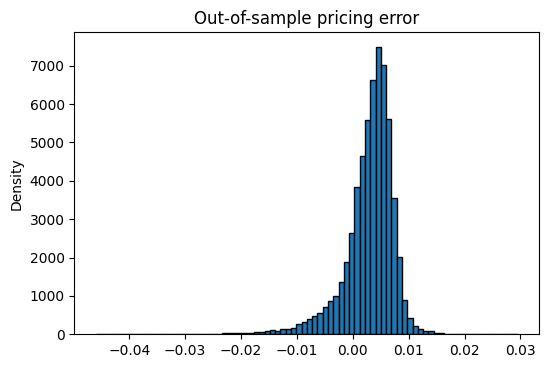

In [ ]:
preds_test= mlp.predict(X_test)
pricing_error_test = preds_test - y_test
plt.figure(dpi=100)
plt.hist(pricing_error_test, bins= 80, edgecolor='black')
plt.title("Out-of-sample pricing error")
plt.ylabel("Density")
plt.show()

In [ ]:
rmse = mean_squared_error(preds_test, y_test)**0.5; rmse # root mean squared error

0.0054567341810209365

In [ ]:
print("Descriptive Statistics (Train): ", stats.describe(preds_train)) # Excess Kurtosis (Fisher) around 0 --> Normal
print("")
print("Descriptive Statistics (Test): ", stats.describe(preds_test)) # Excess Kurtosis (Fisher) around 0 --> Normal

Descriptive Statistics (Train):  DescribeResult(nobs=60000, minmax=(-0.003624601180669415, 0.9158671894720027), mean=0.2706995885835911, variance=0.031713219564585636, skewness=0.5042777007048314, kurtosis=-0.3119510480392731)

Descriptive Statistics (Test):  DescribeResult(nobs=60000, minmax=(-0.003624601180669415, 0.9158671894720027), mean=0.2706995885835911, variance=0.031713219564585636, skewness=0.5042777007048314, kurtosis=-0.3119510480392731)


## Validating with real data
Thus far we have observed the behavior of the model using the synthetic data. Though the use of synthetic data has allowed us to learn the Black-Scholes model quite accurately, we have yet to see how the model performs using real data. Plus, we could also gauge whether models trained in real data are able to better price options in the market.

Nonetheless, it is worth noting that a common option trading strategy is to determine whether an option is undervalued or fairly valued with respect to price and the price outputed by Black-Scholes. With this in mind, if our model misprices an option with a higher price, it could be an indicator that said option is undervalued

**Important** by the time the data  for this article was collected, the current risk-free rate was 0.88%



### UKX Bloomberg Data
To start the validation, we pulled options data using a Bloomberg terminal. To limit the size of query, we extracted the data for around ~1600 calls for stocks in the UKX 100. 



In [ ]:
ukx = pd.read_csv(path+'data/UKX_Calls.csv')
ukx= ukx.dropna()
ukx.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,4732.0,1.0,0.09,0.000000,0.392236,0.0088,4731.0
1,4732.0,1.0,0.34,11.949099,0.392236,0.0088,4731.0
2,4732.0,1.0,0.02,0.000000,0.392236,0.0088,4731.0
3,2094.0,1.0,0.09,0.000000,0.529784,0.0088,2093.0
4,2094.0,1.0,0.34,4.424667,0.529784,0.0088,2093.0


Though it might seem that this data is normalized already, such is not the case. So just as before, we normalize by dividing by the strike

In [ ]:
ukx["Stock Price"] = ukx["Stock Price"]/ukx["Strike Price"]
ukx["Call Price"] = ukx["Call Price"]/ukx["Strike Price"]
ukx["Strike Price"] = ukx["Strike Price"]/ukx["Strike Price"]

Now we split the data and see how the model predicts

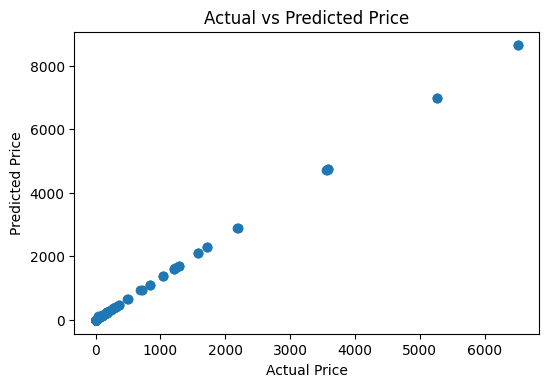

In [ ]:
X_ukx = ukx.drop('Call Price', axis=1)
Y_ukx = ukx['Call Price']
preds_ukx= mlp.predict(X_ukx)
plt.figure(dpi=100)
plt.scatter(preds_ukx, Y_ukx)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.show()

The graph seems to have little deviations. Let's see the $R^2$ for this regression

In [ ]:
r2_score(Y_ukx, preds_ukx)

0.9386439874242171

We can also see the distribution of the errors. Since the data is not simulated using a normal distribution, the may not be normal


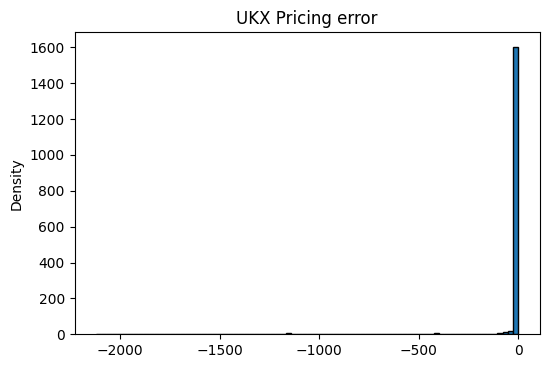

In [ ]:
pricing_error_test = preds_ukx - Y_ukx
plt.figure(dpi=100)
plt.hist(pricing_error_test, bins= 80, edgecolor='black')
plt.title("UKX Pricing error")
plt.ylabel("Density")
plt.show()

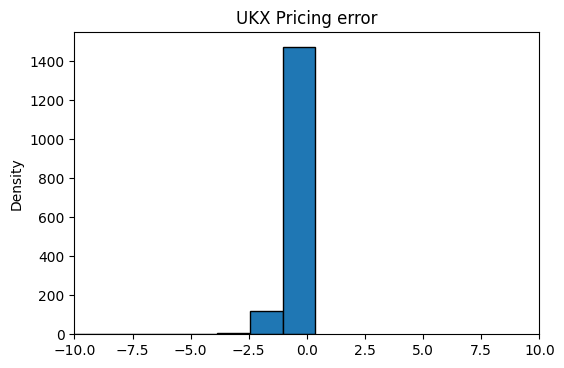

In [ ]:
plt.figure(dpi=100)
plt.hist(pricing_error_test, bins= 1500, edgecolor='black')
plt.title("UKX Pricing error")
plt.ylabel("Density")
plt.xlim(-10, 10)
plt.show()

All our results seem to be quite close to reality, with very few exceptions where our error prediction is quite off
#### SHOULD WE WRITE MORE STUFF HERE? LIKE SOME BS ON THE RESULTS FOR THIS DATASET?



## S&P500 Scraped Data
To finalize the exploration on the performance of this model, we will see how the model behaves when put it against data scraped from S&P500 options.

To gather the data and generate the dataset, we created [this scraping algorithm](https://github.com/jknaudt21/Option-Scraper-BlackScholes). We made a dataset of ~5100 entries

Again, we will normalize the dataset as before.



In [15]:
snp = pd.read_csv(path+'data/SNP.csv')
snp= snp.dropna()
snp["Stock Price"] = snp["Stock Price"]/snp["Strike Price"]
snp["Call Price"] = snp["Call Price"]/snp["Strike Price"]
snp["Strike Price"] = snp["Strike Price"]/snp["Strike Price"]
snp.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,2.095500,1.0,0.008068,0.0,0.4461,0.0088,1.097500
1,1.862667,1.0,0.008068,0.0,0.4461,0.0088,0.864444
2,1.764632,1.0,0.008068,0.0,0.4461,0.0088,0.766316
3,1.676400,1.0,0.008068,0.0,0.4461,0.0088,0.678000
4,1.524000,1.0,0.008068,0.0,0.4461,0.0088,0.525455


Time to see how the model performs on S&P data

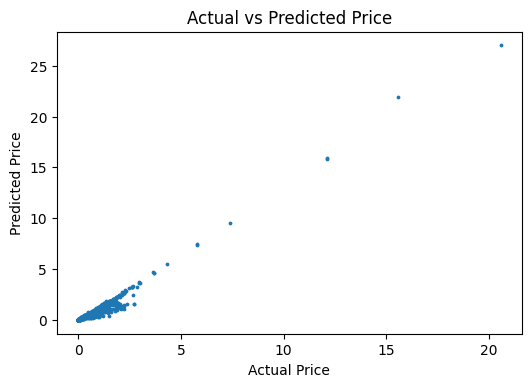

In [20]:
X_snp = snp.drop('Call Price', axis=1)
Y_snp = snp['Call Price']
preds_snp= mlp.predict(X_snp)
plt.figure(dpi=100)
plt.scatter(preds_snp, Y_snp, s=3)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.show()

Here we can observe some more variation, yet the model still finds some success. What about $R^2$?

In [24]:
r2_score(Y_snp, preds_snp)

0.9386346534165548

The results are outstandingly similar to the UKX. This is indicative that the model might be missing feature data to increase accuracy. Regardless, an $R^2$ of 93% is still quite good considering that this is real data 

Finally, lets observe the distribution of the errors 

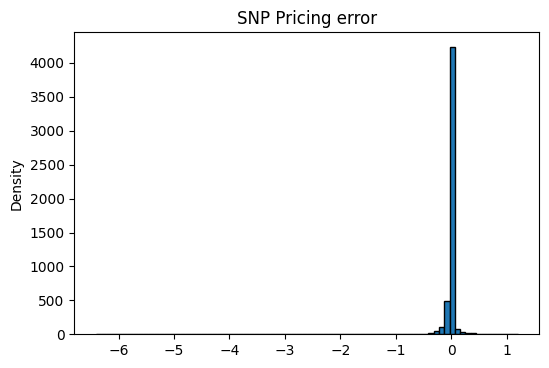

In [26]:
pricing_error_test = preds_snp - Y_snp
plt.figure(dpi=100)
plt.hist(pricing_error_test, bins= 80, edgecolor='black')
plt.title("SNP Pricing error")
plt.ylabel("Density")
plt.show()

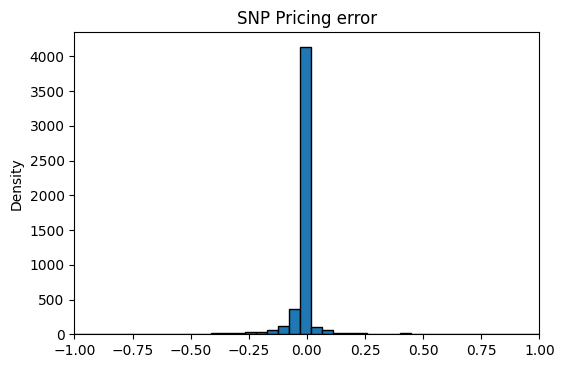

In [29]:
plt.figure(dpi=100)
plt.hist(pricing_error_test, bins= 160, edgecolor='black')
plt.title("SNP Pricing error")
plt.ylabel("Density")
plt.xlim(-1, 1)
plt.show()

Results seem to be normally distributed and this time quite small

## Conclusion
In this research project we validated Culkin and Das conclusion: machine learning is facing a rebirth that has found applications in highly dynamic fields such as finance.

Certain pricing schemes in finance may be non-linear (such as Black-Scholes) and may undergo significant calculation to an answer. Most people without knowledge